### Skrypt do scrapowania _scores.frisbee.pl_
Tu wykorzystany do pobrania danych o stratach z poszczególnych meczów.


#### Ustawienia, importy i deklaracje funkcji

In [126]:
# choose server
server = 'http://scores.frisbee.pl'
#server = 'http://aleztalerz.ultiscores.com'

In [127]:
# url wrappers
def getMobileMatchUrl(uri):
    return '%s/mobile/?view=stats&game=%d' % (server,uri)

def getMobileTeamMatchesUrl(uri):
    return '%s/mobile/?view=team&id=%d' % (server,uri)

def getFullMatchUrl(uri):
    return '%s/?view=gameplay&Game=%d' % (server,uri)

def getFullTeamMatchesUrl(uri):
    return '%s/?view=teamcard&Team=%d' % (server,uri)

def getFullPoolStatusUrl(uri):
    return '%s/?view=poolstatus&Pool=%d' % (server, uri)

# diacritics and accents taming
def rmdiacritics(char):
    '''
    Return the base character of char, by "removing" any
    diacritics like accents or curls and strokes and the like.
    '''
    desc = ud.name(unicode(char))
    cutoff = desc.find(' WITH ')
    if cutoff != -1:
        desc = desc[:cutoff]
    return ud.lookup(desc)

def strip_accents(string):
        return ''.join(rmdiacritics(c) for c in string)

# fake user agent
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

In [208]:
# urllib2- and BS-based methods with (hopefully) self-explainatory names
import urllib2
from bs4 import BeautifulSoup

# get teamTournamentIds (teamIds valid during a given tournament) for a given seriesId
def get_teamTournamentIds_for_seriesId(seriesId):
    req = urllib2.Request(getFullPoolStatusUrl(seriesId), headers=hdr)
    page = urllib2.urlopen(req)
    soup = BeautifulSoup(page,"lxml")
    
    tags = soup.find_all('td',{'class':'tdcontent'})[0].find_all('a')
    return [int(t.get('href')[t.get('href').index('Team=')+5:]) for t in tags if 'Team=' in t.get('href')]

# get team name and matches for a given teamTournamentId
def get_data_for_teamTournamentId(teamTournamentId):
    req = urllib2.Request(getMobileTeamMatchesUrl(teamTournamentId), headers=hdr)
    page = urllib2.urlopen(req)
    soup = BeautifulSoup(page,"lxml")
    
    teamName = soup.find('strong').text
    matchIds = [int(tag['href'][-4:]) for tag in soup.find_all('a',{'class':'statslink'})]
    return teamName, matchIds

# get turnovers of a given teamName in a given matchId
def get_turnovers_for_matchId(matchId,teamName,mode='ids'):
    req = urllib2.Request(getFullMatchUrl(matchId), headers=hdr)
    page = urllib2.urlopen(req)
    soup = BeautifulSoup(page,"lxml")

    teams = [tag.text for tag in soup.find_all('th',{'class':'mixed center'})]
    our_home_or_guest = 'home' if teamName == teams[0] else 'guest'
    their_home_or_guest = 'home' if home_or_guest=='guest' else 'guest'
    their_team_name = teams[0] if teamName == teams[1] else teams[1]

    history_url = soup.find_all('a')[-1].get('href') # tylko tu sa id druzyn!
    home_id = int(history_url[history_url.index('&Team1=')+7 : history_url.index('&Team2=')])
    away_id = int(history_url[history_url.index('&Team2=')+7 : ])
    if our_home_or_guest == 'home':
        our_team_id = home_id
        their_team_id = away_id
    else:
        our_team_id = away_id
        their_team_id = home_id

    # mozna tez samemu liczyc i nie ufac temu co jest w tabelce
    our_turnovers = soup.find('table',{'class':'gamestatstable'}).find_all('td',{'class':our_home_or_guest})[-2].text
    #their_turnovers = soup.find('table',{'class':'gamestatstable'}).find_all('td',{'class':their_home_or_guest})[-2].text
    
    if mode == 'ids':
        try:
            our_turnovers = int(our_turnovers)
        except:
            our_turnovers = -1
        return (our_team_id,their_team_id,our_turnovers)
    else: #if mode == 'names'
        try:
            our_turnovers = int(our_turnovers)
        except:
            our_turnovers = -1
        return (teamName,their_team_name,our_turnovers)
        

#### Generowanie tabeli z wynikami

In [209]:
%%time 
# around 4 mins
seriesId = 1572
teamTournamentIds = get_teamTournamentIds_for_seriesId(seriesId)

results = [get_turnovers_for_matchId(matchId, get_data_for_teamTournamentId(teamTournamentId)[0],'names' )\
           for teamTournamentId in teamTournamentIds for matchId in get_data_for_teamTournamentId(teamTournamentId)[1]]

Wall time: 3min 48s


In [248]:
import pandas as pd
df = pd.DataFrame(results,columns=['Team','Opposition','Turnovers'])
print df.head(10)

                 Team         Opposition  Turnovers
0  muJAHedini dysku 1   Ultimatum Szkwał         10
1  muJAHedini dysku 1         Zawierucha          9
2  muJAHedini dysku 1       Tłuste Dyski          9
3  muJAHedini dysku 1  Reach for the Sky          4
4  muJAHedini dysku 1     Chewra Badgers         18
5  muJAHedini dysku 1       BC Kosmodysk         11
6  muJAHedini dysku 1  Grandmaster Flash         16
7  muJAHedini dysku 1             4hands          9
8  muJAHedini dysku 1         Uwaga Pies          7
9  muJAHedini dysku 1             RJP II          3


zapis do pliku

In [210]:
df.to_csv('turnovers_%d.csv'%seriesId,index=False) # wont work in 'names' mode

UnicodeEncodeError: 'ascii' codec can't encode character u'\u0142' in position 15: ordinal not in range(128)

#### Analizy

In [211]:
import matplotlib.pyplot as plt
import numpy as np

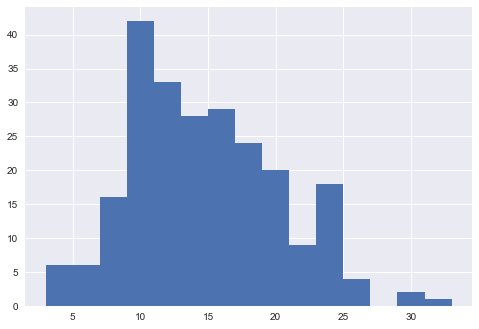

In [212]:
# histogram turnow w meczu na druzyne
df = df.loc[df.Turnovers>-1]

plt.hist(df.Turnovers,15)
plt.show()

[[ 1.         -0.33021428]
 [-0.33021428  1.        ]]


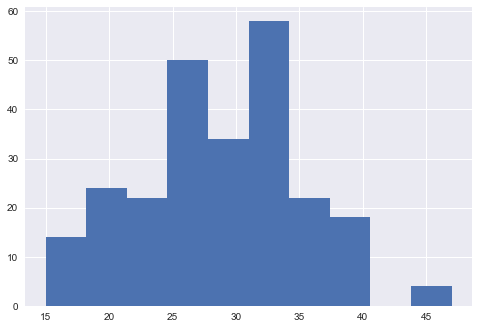

In [213]:
tmp_df = df.rename(columns={'Team':'Opposition','Opposition':'Team'})
merged = pd.merge(df,tmp_df, on=['Team','Opposition']) # kazdy mecz jest dwa razy!

print np.corrcoef(merged.Turnovers_x,merged.Turnovers_y)
merged['Total Turnovers'] = merged.Turnovers_x+merged.Turnovers_y
plt.hist(merged['Total Turnovers'])
plt.show()

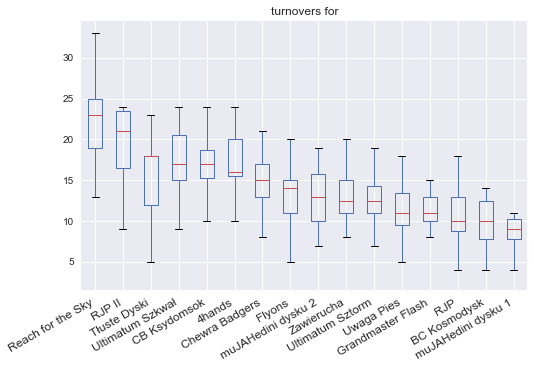

In [244]:
grouped = df.groupby('Team')
df2 = pd.DataFrame({col:vals['Turnovers'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=False,inplace=True)
df2 = df2[meds.index]
axs=df2.boxplot()
plt.gcf().autofmt_xdate()
plt.title('turnovers for')
plt.show()

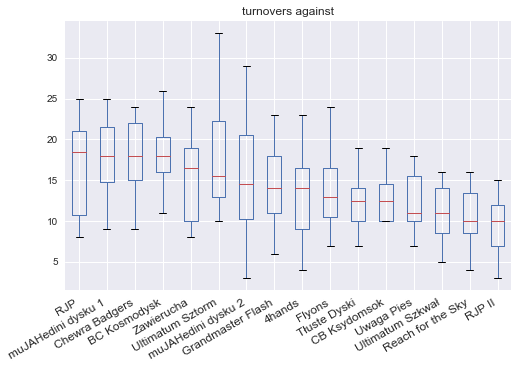

In [245]:
grouped = df.groupby('Opposition')
df2 = pd.DataFrame({col:vals['Turnovers'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=False,inplace=True)
df2 = df2[meds.index]
axs=df2.boxplot()
plt.gcf().autofmt_xdate()
plt.title('turnovers against')
plt.show()

                   Turnovers for          
                      mean turns std turns
Team                                      
4hands                 17.266667  4.300609
BC Kosmodysk           10.500000  4.871687
CB Ksydomsok           17.285714  4.322189
Chewra Badgers         13.357143  5.943414
Flyons                 13.133333  3.563038
Grandmaster Flash      11.866667  4.437932
RJP                    10.812500  3.763310
RJP II                 19.266667  4.949266
Reach for the Sky      22.400000  5.590809
Tłuste Dyski           13.733333  6.638273
Ultimatum Szkwał       17.333333  4.864840
Ultimatum Sztorm       13.562500  4.396495
Uwaga Pies             11.466667  3.398879
Zawierucha             12.200000  5.115802
muJAHedini dysku 1      9.437500  4.257836
muJAHedini dysku 2     11.866667  5.040786


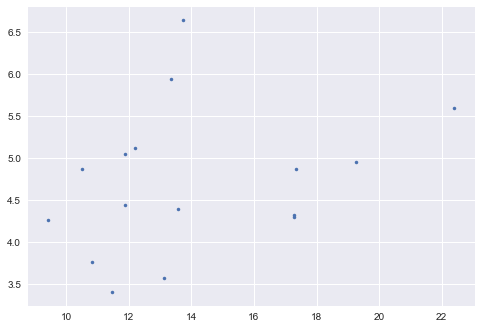

In [255]:
aggs = {'Turnovers' : {'mean turns': 'mean','std turns': 'std'}}
grouped = df.groupby('Team')
aggregated = grouped.agg(aggs)
print aggregated.rename(columns={'Turnovers' : 'Turnovers for'})
plt.plot(aggregated.Turnovers['mean turns'],aggregated.Turnovers['std turns'],'.')
plt.show()

agg_for = aggregated.rename(columns={'Turnovers' : 'Turnovers for'})

                   Turnovers against          
                          mean turns std turns
Opposition                                    
4hands                     13.066667  4.861902
BC Kosmodysk               18.312500  4.011961
CB Ksydomsok               12.285714  4.046434
Chewra Badgers             16.214286  6.896806
Flyons                     13.600000  4.532423
Grandmaster Flash          15.066667  5.799836
RJP                        16.687500  5.816285
RJP II                      9.600000  3.660601
Reach for the Sky          10.266667  3.788454
Tłuste Dyski               11.533333  5.012366
Ultimatum Szkwał           11.266667  4.558613
Ultimatum Sztorm           17.562500  6.345274
Uwaga Pies                 12.066667  3.555010
Zawierucha                 13.866667  6.490286
muJAHedini dysku 1         17.937500  4.739462
muJAHedini dysku 2         14.266667  8.145697


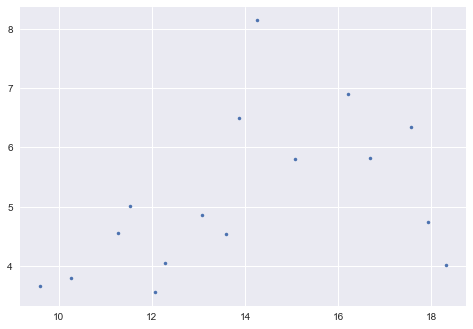

In [256]:
aggs = {'Turnovers' : {'mean turns': 'mean','std turns': 'std'}}
grouped = df.groupby('Opposition')
aggregated = grouped.agg(aggs)
print aggregated.rename(columns={'Turnovers' : 'Turnovers against'})
plt.plot(aggregated.Turnovers['mean turns'],aggregated.Turnovers['std turns'],'.')
plt.show()

agg_against = aggregated.rename(columns={'Turnovers' : 'Turnovers against'})

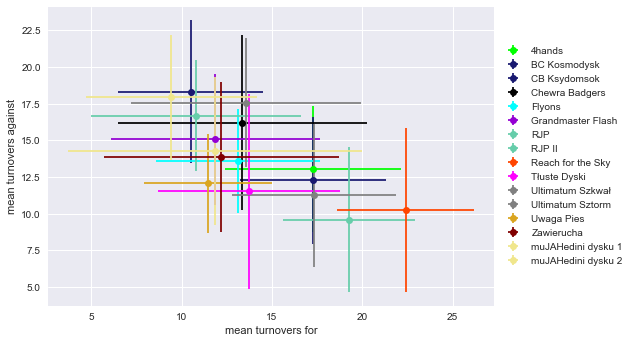

In [292]:
agg_for_mean = agg_for['Turnovers for']['mean turns']
agg_for_std = agg_for['Turnovers for']['std turns']
agg_against_mean = agg_against['Turnovers against']['mean turns']
agg_against_std = agg_against['Turnovers against']['std turns']

teams = ['4hands', u'BC Kosmodysk' , u'CB Ksydomsok', u'Chewra Badgers',\
       u'Flyons', u'Grandmaster Flash', u'RJP', u'RJP II',\
       u'Reach for the Sky', u'Tłuste Dyski', u'Ultimatum Szkwał',\
       u'Ultimatum Sztorm', u'Uwaga Pies', u'Zawierucha',\
       u'muJAHedini dysku 1', u'muJAHedini dysku 2']
colors = {u'4hands':'lime', u'BC Kosmodysk':'midnightblue', u'CB Ksydomsok':'midnightblue', u'Chewra Badgers':'k',\
       u'Flyons':'aqua', u'Grandmaster Flash':'darkviolet', u'RJP':'mediumaquamarine', u'RJP II':'mediumaquamarine',\
       u'Reach for the Sky':'orangered', u'Tłuste Dyski':'magenta', u'Ultimatum Szkwał':'grey',\
       u'Ultimatum Sztorm':'grey', u'Uwaga Pies':'goldenrod', u'Zawierucha':'maroon',\
       u'muJAHedini dysku 1':'khaki', u'muJAHedini dysku 2':'khaki'}

for team in teams:
    plt.errorbar(agg_for_mean[team],agg_against_mean[team],agg_for_std[team],agg_against_std[team],'o',color=colors[team],ecolor=colors[team],label=team)
plt.xlabel('mean turnovers for')
plt.ylabel('mean turnovers against')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [315]:
mat = np.matrix([agg_for_mean,agg_against_mean])
from sklearn.decomposition import PCA
pca = PCA()
df = pd.DataFrame(pca.fit_transform(mat.T),columns=['pca1','pca2'],index=teams)
print df.sort_values('pca1')

                        pca1      pca2
muJAHedini dysku 1 -6.089911 -0.537095
BC Kosmodysk       -5.440460 -1.457826
RJP                -4.245156 -0.313479
Ultimatum Sztorm   -2.508904 -2.618594
Grandmaster Flash  -2.447427  0.398235
muJAHedini dysku 2 -1.984432  1.050643
Chewra Badgers     -1.896105 -1.400263
Zawierucha         -1.481098  1.183932
Uwaga Pies         -1.037402  3.076262
Flyons             -0.565624  0.861242
Tłuste Dyski        1.119751  2.199383
4hands              3.113813 -1.095958
CB Ksydomsok        3.581317 -0.470107
Ultimatum Szkwał    4.209918  0.333378
RJP II              6.751142  0.573658
Reach for the Sky   8.920578 -1.783410
